In [1]:
%matplotlib inline

In [2]:
import requests
import json
import csv
import numpy as np
import matplotlib.pyplot as plt
from sortedcontainers import SortedDict

counties_population = dict()

# process data INS
with open('data_ins/demographic_data_2015.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if row:
            if 'Valoare' not in row[6] and 'Regiune' not in row[3] and 'REGIUNE' not in row[3]:
                counties_population[row[3].strip()] = int(row[6].strip())

vaccines = dict()
vaccines_all = dict()

# process data DATA.GOV.RO
with open('data_gov_ro/vaccinari2017/data/copii.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    for row in reader:
        if row[0] not in vaccines:
            vaccines[row[0]] = dict()
        if row[2] not in vaccines[row[0]]:
            vaccines[row[0]][row[2]] = int(row[3])
        else:
            vaccines[row[0]][row[2]] += int(row[3])

for k, v in vaccines.items():
    total_vaccines = 0
    for k2, v2 in v.items():
        total_vaccines += v2
    vaccines_all[k] = total_vaccines

rujeola = list()

# read data from Agerpress: https://www.agerpres.ro/sanatate/2017/03/15/epidemia-de-rujeola-in-romania-3-446-de-cazuri-inregistrate-in-37-de-judete-cu-17-persoane-decedate-grupaj--11-54-54
with open('mass-media/ancheta_agerpress.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if row[0] != 'Judet':
            judet_name = row[0]
            no_cases = int(row[1])
            vaccination_ratio = vaccines_all[judet_name] / counties_population[judet_name]
            rujeola.append({'judet': judet_name, 'no_cases': no_cases, 'vaccination_ratio': vaccines_all[judet_name] / counties_population[judet_name] * 100})

# Order by infections and vaccination ratio

In [3]:
sorted_rujeola1 = sorted(rujeola, key=lambda k: k['no_cases'], reverse=True)
sorted_rujeola2 = sorted(rujeola, key=lambda k: k['vaccination_ratio'], reverse=True)

In [4]:
counter_infected1 = [it['no_cases'] for it in sorted_rujeola1]
counter_vaccinated1 = [it['vaccination_ratio'] for it in sorted_rujeola1]
counter_infected2 = [it['no_cases'] for it in sorted_rujeola2]
counter_vaccinated2 = [it['vaccination_ratio'] for it in sorted_rujeola2]

# Plot number of infections

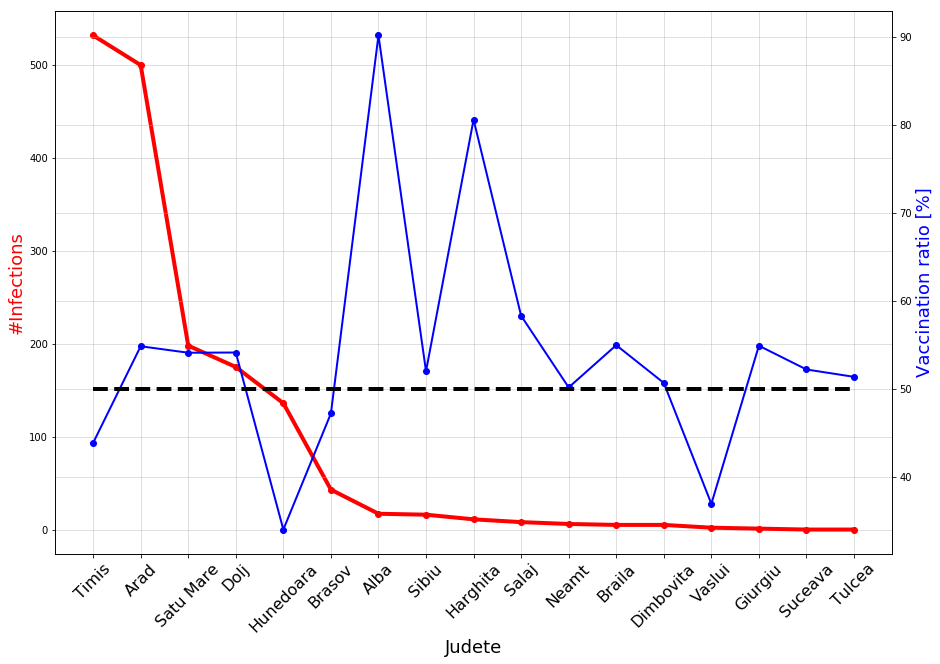

In [5]:
fig, ax1 = plt.subplots(figsize=(15,10))

x_ticks = np.arange(0, len(sorted_rujeola1), 1)
x_ticks_labels = [it['judet'] for it in sorted_rujeola1]
half_points = [50 for it in sorted_rujeola1]

ax2 = ax1.twinx()

ax1.plot(x_ticks, counter_infected1, 'r', linewidth=4.0)
ax1.plot(x_ticks, counter_infected1, 'ro', linewidth=4.0)

ax2.plot(x_ticks, counter_vaccinated1, 'b', linewidth=2.0)
ax2.plot(x_ticks, counter_vaccinated1, 'bo', linewidth=2.0)
ax2.plot(x_ticks, half_points, 'k--', linewidth=4.0)

ax1.grid(which='both', alpha=0.5) 
ax2.grid(which='both', alpha=0.5) 
ax1.set_xticklabels(x_ticks_labels, rotation='45', fontsize=16)
ax1.set(xticks=x_ticks, xticklabels=x_ticks_labels)

ax1.locator_params(nbins=len(x_ticks)*2, axis='x')
ax2.locator_params(nbins=len(x_ticks)*2, axis='x')

ax1.set_xlabel('Judete', fontsize=18)
ax1.set_ylabel('#Infections', color='r', fontsize=18)
ax2.set_ylabel('Vaccination ratio [%]', color='b', fontsize=18)

plt.show()

# Plot vaccination rates

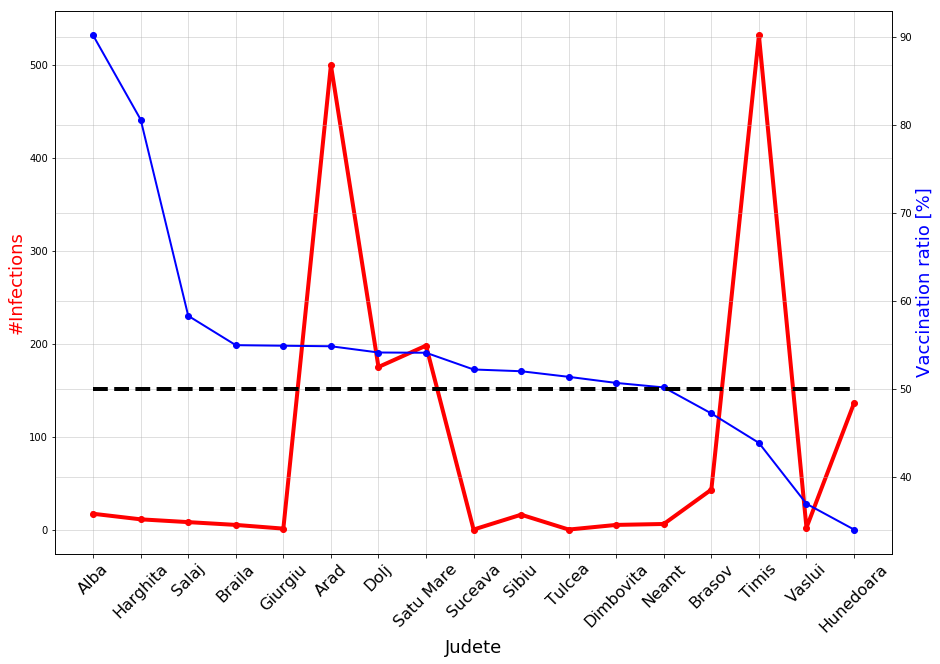

In [6]:
fig, ax1 = plt.subplots(figsize=(15,10))

x_ticks = np.arange(0, len(sorted_rujeola2), 1)
x_ticks_labels = [it['judet'] for it in sorted_rujeola2]
half_points = [50 for it in sorted_rujeola2]

ax2 = ax1.twinx()

ax1.plot(x_ticks, counter_infected2, 'r', linewidth=4.0)
ax1.plot(x_ticks, counter_infected2, 'ro', linewidth=4.0)

ax2.plot(x_ticks, counter_vaccinated2, 'b', linewidth=2.0)
ax2.plot(x_ticks, counter_vaccinated2, 'bo', linewidth=2.0)
ax2.plot(x_ticks, half_points, 'k--', linewidth=4.0)

ax1.grid(which='both', alpha=0.5) 
ax2.grid(which='both', alpha=0.5) 
ax1.set_xticklabels(x_ticks_labels, rotation='45', fontsize=16)
ax1.set(xticks=x_ticks, xticklabels=x_ticks_labels)

ax1.locator_params(nbins=len(x_ticks)*2, axis='x')
ax2.locator_params(nbins=len(x_ticks)*2, axis='x')

ax1.set_xlabel('Judete', fontsize=18)
ax1.set_ylabel('#Infections', color='r', fontsize=18)
ax2.set_ylabel('Vaccination ratio [%]', color='b', fontsize=18)

plt.show()

# Plot on a map

In [9]:
import plotly.plotly as py
from plotly.graph_objs import *
import os

mapbox_access_token = os.environ['MAPBOX_ACCESS_TOKEN']

city_lat = ['45.74', '46.18', '47.80', '44.16', '45.79', '45.65', '46.08', '45.79', '46.49', '47.20', '46.97', '45.26', '44.92', '46.64', '43.90', '47.66', '45.17']
city_long = ['21.20', '21.31', '22.85', '23.63', '22.99', '25.60', '23.56', '24.12', '25.64', '23.21', '26.38', '27.95', '25.42', '27.72', '25.96', '26.27', '28.79']

marker_size_infected = [ci/15 for ci in counter_infected1]
marker_size_vaccinated = [cv/3 for cv in counter_vaccinated1]

data = Data([
    Scattermapbox(
        lat=city_lat,
        lon=city_long,
        mode='markers+text',
        marker=Marker(size=marker_size_vaccinated, color='blue'),
        text=["Timis", "Arad", "Satu Mare", "Dolj", "Hunedoara", "Brasov", "Alba", "Sibiu", "Harghita", "Salaj", "Neamt", "Braila", "Dimbovita", "Vaslui", "Giurgiu", "Suceava", "Tulcea"],
    ),
    Scattermapbox(
        lat=city_lat, 
        lon=city_long,
        mode='markers+text',
        marker=Marker(size=marker_size_infected, color='red'),
        text=["Timis", "Arad", "Satu Mare", "Dolj", "Hunedoara", "Brasov", "Alba", "Sibiu", "Harghita", "Salaj", "Neamt", "Braila", "Dimbovita", "Vaslui", "Giurgiu", "Suceava", "Tulcea"],
    )
])

layout = Layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=46.00,
            lon=25.00
        ),
        pitch=0,
        zoom=5
    ),
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Multiple Mapbox')